In [1]:
from tensorflow import keras

from tensorflow.keras import models, layers
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

from tqdm import tqdm
import matplotlib.pyplot as plt 
import numpy as np 

In [2]:
# Preparing the dataset and creating the features and target arrays

n_sims = 10000

x = []
y = []

for i in tqdm(range(n_sims), desc='Carregando dados', ascii=True):
    data = np.load(f'input/data_{i+1}.npy')
    x.append(data[:, :2])
    y.append(data[0, 2])  # equivalente a data[:, 2:][0][0]

x = np.array(x)
y = np.array(y)

norm = y.max()
# Normalização
y /= y.max()


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25)

Carregando dados: 100%|##########| 10000/10000 [00:03<00:00, 2884.14it/s]


In [44]:
early_stopping = keras.callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   
    patience=5,          
    verbose=1,          
    factor=0.5,          
    min_lr=0.00001       
)

learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # Initial learning rate for training
    decay_steps=100,            # Number of steps before decaying the learning rate
    decay_rate=0.5,              # Rate at which the learning rate decreases
)

lr_callback = keras.callbacks.LearningRateScheduler(learning_rate_schedule)


In [45]:
# defining the model

model = models.Sequential()

model.add(layers.Flatten())


model.add(layers.Dense(16, activation='relu'))
# model.add(layers.Dropout(.3))
model.add(layers.Dense(16, activation='relu'))

model.add(layers.Dense(1))

model.compile(loss=keras.losses.MeanSquaredError(), optimizer='nadam', metrics=keras.metrics.MeanAbsoluteError())


history = model.fit(x_train, y_train, validation_split=.1, epochs=25, batch_size=8, verbose=1, callbacks=[early_stopping, reduce_lr, lr_callback])

Epoch 1/25
844/844 [==============================] - 5s 5ms/step - loss: 21.4245 - mean_absolute_error: 0.4357 - val_loss: 4.2381e-05 - val_mean_absolute_error: 0.0053 - lr: 0.0100
Epoch 2/25
844/844 [==============================] - 4s 5ms/step - loss: 4.6434e-05 - mean_absolute_error: 0.0056 - val_loss: 3.5731e-05 - val_mean_absolute_error: 0.0049 - lr: 0.0099
Epoch 3/25
844/844 [==============================] - 4s 5ms/step - loss: 0.0101 - mean_absolute_error: 0.0455 - val_loss: 2.8442e-04 - val_mean_absolute_error: 0.0164 - lr: 0.0099
Epoch 4/25
844/844 [==============================] - 4s 5ms/step - loss: 0.0106 - mean_absolute_error: 0.0308 - val_loss: 2.4766e-06 - val_mean_absolute_error: 0.0013 - lr: 0.0098
Epoch 5/25
844/844 [==============================] - 4s 5ms/step - loss: 0.0044 - mean_absolute_error: 0.0261 - val_loss: 8.5176e-05 - val_mean_absolute_error: 0.0078 - lr: 0.0097
Epoch 6/25
836/844 [============================>.] - ETA: 0s - loss: 0.0019 - mean_absolu

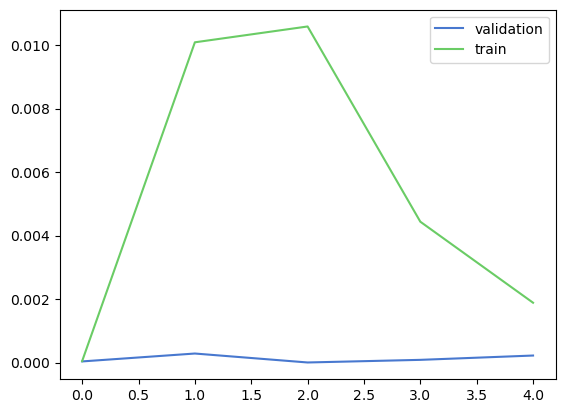

In [46]:
plt.plot(history.history['val_loss'][1:], label='validation')
plt.plot(history.history['loss'][1:], label='train')

plt.legend()
plt.show()

In [47]:
y_pred = model.predict(x_test)


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)



79/79 [==============================] - 0s 1ms/step


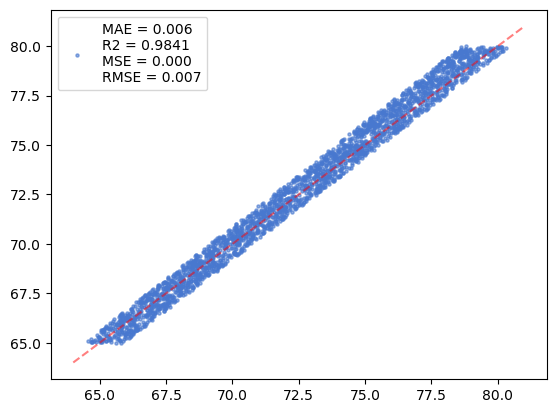

In [48]:
plt.style.use('seaborn-v0_8-muted')

linha = np.linspace(64, 81)
# linha = np.linspace(.28, .35, 2500)


plt.scatter(y_pred*norm, y_test*norm, s=5, alpha=.6, label=f'MAE = {mae:.3f}\nR2 = {r2:.4f}\nMSE = {mse:.3f}\nRMSE = {rmse:.3f}')
plt.plot(linha, linha, alpha=.5, c='red', ls='--')

plt.legend()
plt.savefig("imagens/metrics_h0_dense")
# plt.savefig("imagens/metrics_omega_dense")
plt.show()

In [49]:
# forecasting "real" H(0)

real = np.load('input/data_real80.npy')
real = real[real[:, 1].argsort()]

real = real.reshape(-1,80,2)

In [50]:

final_real = model.predict(real, verbose=0)

In [51]:
final_real*norm

array([[67.47816]], dtype=float32)

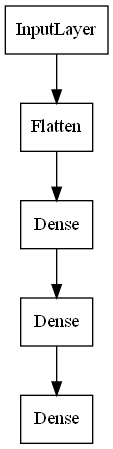

In [52]:
keras.utils.plot_model(model, to_file='imagens/model_dense.png', show_shapes=False, show_layer_names=False)


In [ ]:
model.save('models/dense')

INFO:tensorflow:Assets written to: models/dense.tf\assets
